# [COM6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**2 marks**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**2 marks**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**2 marks**)
    - **Output layer** with a **softmax** activation. (**2 marks**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**2 marks**)
    - Perform a **Forward pass** to compute intermediate outputs (**5 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**12 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**4 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**5 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**2 marks**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**7 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**8 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**5 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in [Intro to Python for NLP](https://sheffieldnlp.github.io/com6513/assets/labs/a0_python_intro.pdf) (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 60. It is worth 60\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 23 Apr 2021** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc
from tqdm.notebook import tqdm

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
train_pd = pd.read_csv('../Assignment2/data_topic/train.csv', names = ['label', 'Sentence'])
test_pd = pd.read_csv('../Assignment2/data_topic/test.csv', names = ['label', 'Sentence'])
dev_pd = pd.read_csv('../Assignment2/data_topic/dev.csv', names = ['label', 'Sentence'])

In [3]:
# Transform pandas to numpy
train_np = train_pd.values
test_np = test_pd.values
dev_np = dev_pd.values

In [4]:
train_pd.head()

,label,Sentence
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [6]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    
    tokenRE = re.compile(token_pattern)
    
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
    
    
    # this is to store the ngrams to be returned
    x = []
    

    
    if ngram_range[0]==1:
        x = x_uni


    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):

    # ignore unigrams
        if n==1: continue

        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1]. 
        # Note that x_uni and x_uni[1:] have different lenghts
        # but zip ignores redundant elements at the end of the second list
        # Alternatively, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)


    for n in ngrams:
        for t in n:
            x.append(t)

    if len(vocab)>0:
        x = [w for w in x if w in vocab]
        
    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [7]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    
    tokenRE = re.compile(token_pattern)
    
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
    
    # interate through each raw text
    for x in X_raw:
        
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, 
                                 stop_words=stop_words)
        
        #update doc and ngram frequencies 
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set. 
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
    
    # keep the top N most freqent 
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) 
                     if w[0] in vocab])
    
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [8]:
# Because we need to extract words of each document, ngram_range should be (1, 1)
# Min_df aims to limite the number of words and get those more important words, we choose min_df=5. Other numbers of min_df can also be used
# The min_df becomes smaller, the embedding matrix will become bigger which may need more time to calculate
vocab, df, ngram_counts = get_vocab(train_np[:,1], stop_words=stop_words,ngram_range=(1,1), min_df=5)

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [9]:
id2word = dict(enumerate(vocab))
word2id = dict(zip(vocab, range(len(vocab))))

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [10]:
def document2words(X_raw, vocab):
    d2w_list = list() # A list to store the results
    for doc in X_raw:
        doc2word = extract_ngrams(doc, ngram_range=(1,1), vocab=vocab) # Get words for each document
        d2w_list.append(doc2word)
    return d2w_list

In [11]:
doc2words_train = document2words(train_np[:,1], vocab)
doc2words_test = document2words(test_np[:,1], vocab)
doc2words_dev = document2words(dev_np[:,1], vocab)

Then convert them into lists of indices in the vocabulary:

In [12]:
def words2idx(doc2word):
    w2i_list = list() # Word to index list
    for doc in doc2word:
        w2i = [word2id[word] for word in doc]
        w2i_list.append(w2i)
    return w2i_list

In [13]:
word2id_train = words2idx(doc2words_train)
word2id_test = words2idx(doc2words_test)
word2id_dev = words2idx(doc2words_dev)

Put the labels `Y` for train, dev and test sets into arrays: 

In [14]:
train_label = train_np[:,0]
test_label = test_np[:,0]
dev_label = dev_np[:,0]

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [15]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    W = dict()
    # Embedding layer
    W[0] = np.random.uniform(-init_val, init_val, (vocab_size, embedding_dim)).astype(np.float32)
    
    # Hidden layer
    row_num, k = embedding_dim, 1
    for i in hidden_dim:
        col_num = hidden_dim[k-1]
        W[k] = np.random.uniform(-init_val, init_val, (row_num, col_num)).astype(np.float32)
        row_num = col_num
        k += 1   
        
    # Output layer
    W[len(W)] = np.random.uniform(-init_val, init_val, (row_num, num_classes)).astype(np.float32)
    return W

In [16]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [17]:
def softmax(z):
    
    smax = np.longfloat(np.exp(z - np.max(z)))
    
    sig = smax/np.sum(smax).reshape(-1,1)
    
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [18]:
def categorical_loss(y, y_preds):
    
    l = -np.sum(np.log(np.max(y_preds)))

    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [19]:
def relu(z):
    
    a = z.copy()
    
    a = np.maximum(a, 0)
    
    return a
    
def relu_derivative(z):
    
    dz = z.copy()
    dz[z > 0] = 1
    dz[z <= 0] = 0
    
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [20]:
def dropout_mask(size, dropout_rate):
    
    dropout_vec = np.random.binomial(1, 1-dropout_rate, size).astype(np.float32)
    
    return dropout_vec

In [21]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 0. 0. 1. 1. 1. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [22]:
def forward_pass(x, W, dropout_rate=0.2):
    # Convert the index in x to 1 in a zero array
    x_mtr = np.zeros((1, len(vocab)))
    for i in x:
        x_mtr[0, i] = 1 / len(x)
    x_mtr = x_mtr[0]
    
    out_vals = {}
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    pred = []
    
    pred.append(x_mtr)
    
    for i in range(len(W)):
        x_mtr = x_mtr @ W[i]
        
        # The last layer should be inputed to softmax function to get the probability
        if i == len(W) - 1:
            pred.append(softmax(x_mtr)) 
        else: 
            # Before Activation function
            h_vecs.append(x_mtr)
            
            # Activation Function
            x_mtr = relu(x_mtr)
            a_vecs.append(x_mtr)
            
            # Dropout vector
            dr_vec = dropout_mask(len(x_mtr), dropout_rate) 
            dropout_vecs.append(dr_vec)
            
            # Do dropout
            x_mtr = x_mtr * dr_vec 
    
            pred.append(x_mtr)
        
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['d'] = dropout_vecs
    out_vals['p'] = pred
    
    return out_vals
    

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [23]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    mtr = np.zeros((1,3))[0]
    mtr[y-1] = 1
    # Store a part of the equation
    F = out_vals['p'][-1] - mtr 
    
    # Freeze the embedding layer
    for i in reversed(range(len(W))):
        if i == len(W)-1:
            grad = np.dot(out_vals['p'][i].reshape(-1,1), F)
        else:
            grad = np.dot(out_vals['p'][i].reshape(-1,1), F * relu_derivative(out_vals['p'][i+1]))
        # Update F
        F = np.dot(F, W[i].T)
        
        # Update weights
        W[i] -= lr * grad
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [24]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):

    training_loss_history = []
    validation_loss_history = []
    epochs_list = []
    index = list(range(len(X_tr)))

    for epoch in tqdm(range(epochs)):
        # Randomly choose data in each epoch
        np.random.shuffle(index)
        training_loss = 0
        for i in index:
            # Forward
            forward = forward_pass(X_tr[i], W, dropout_rate=dropout) 
            # Use backward_pass to update W
            W = backward_pass(X_tr[i], Y_tr[i], W=W, out_vals=forward, lr=lr, freeze_emb=freeze_emb)
            training_loss += categorical_loss(Y_tr[i], forward['p'][-1])/len(X_tr)
        
        training_loss_history.append(training_loss)
        
        # Validation loss
        val_forward = forward_pass(X_dev, W, dropout_rate=0)
        validation_loss = np.sum(categorical_loss(Y_dev, val_forward['p'][-1])) / len(X_dev) 
        validation_loss_history.append(validation_loss)
        
        if print_progress==True:
            print('Epoch:{}   training_loss:{}   validation_loss:{}'.format(epoch+1, training_loss, validation_loss))
        
        # If the change validation loss smaller than tolerance, stop training
        if len(validation_loss_history) > 1: 
            if abs(validation_loss_history[-1] - validation_loss_history[-2]) < tolerance:
                break
        epochs_list.append(epoch)
    print("Stop Epoch: {}".format(epoch+1))            
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [25]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[300], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)
    
X_tr = word2id_train
Y_tr = train_label
X_dev = word2id_dev
Y_dev = dev_label

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W = W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.06, 
                            dropout=0.5,
                            freeze_emb=False,
                            tolerance=0.0001,
                            epochs=15, print_progress=False)

Shape W0 (2203, 300)
Shape W1 (300, 300)
Shape W2 (300, 3)



Stop Epoch: 9


Plot the learning process:

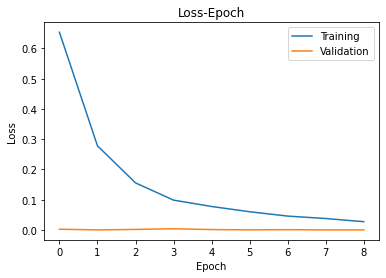

In [26]:
plt.plot(loss_tr, label = "Training")
plt.plot(dev_loss, label = "Validation")
plt.title("Loss-Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

From the figure above, it is clear to see that the model is about right and the training loss is convergence at the end of the training progress.

Compute accuracy, precision, recall and F1-Score:

In [27]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['p'][-1]) 
            for x,y in zip(word2id_test, test_label)]

Y_te = (test_label-1).astype(int)

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8522222222222222
Precision: 0.854069696194529
Recall: 0.8522222222222222
F1-Score: 0.8518192727996725


### Discuss how did you choose model hyperparameters ? 

The results of the model with different parameters have been showed below which indicate that the model with hidden_dim=300, lr=0.06, embedding_dim=300, dropout=0.5 can have the best performance.

After read some materials, we notice that the dropout=0.5 can avoid overfitting and improve the performance of the model. Also, a suitable hidden layer and embedding layer's dimension is very important to improve the performance of the model. When the dimension is too small, the model may not get the features of data very well.


| Example | Hidden_dim  | lr | Embedding_dim| Dropout | F1-Score  |
|:-:|:-:|:-:|:-:|:-:|:-:|
| Example1  | 40 | 0.01  | 300 | 0.2 | 0.805|
| Example2  | 40  |  0.01 | 300 |0.5 | 0.773|
| Example3  | 40  |  0.01 | 40 |0.2  | 0.382|
| Example4  | 40  |  0.01 | 40 |0.5 | 0.338|
| Example5  | 40  |  0.06 | 300| 0.2 | 0.832|
| Example6  | 40  |  0.06 | 300| 0.5 | 0.851|
| Example7  | 40  |  0.06 | 40| 0.2 | 0.845 |
| Example8  | 40  |  0.06 | 40| 0.5 | 0.842|
| Example9  | 300 | 0.01  | 300 |0.2 | 0.825|
| Example10  | 300  |  0.01 | 300 | 0.5| 0.832|
| Example11 | 300  |  0.01 | 40 | 0.2 | 0.797|
| Example12  | 300  |  0.01 | 40 | 0.5| 0.835|
| Example13 | 300  |  0.06 | 300|  0.2| 0.851|
| **Example14**  | 300  |  0.06 | 300| 0.5 | **0.852**|
| Example15  | 300  |  0.06 | 40| 0.2 | 0.827 |
| Example16  | 300  |  0.06 | 40| 0.5 | 0.846|

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [28]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [29]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [36]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[300], num_classes=3)
W[0] = w_glove

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W = W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.06, 
                            dropout=0.5,
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=15,
                            print_progress=False)


Stop Epoch: 2


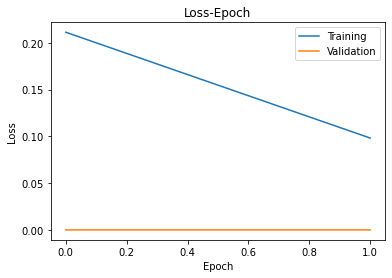

In [37]:
plt.plot(loss_tr, label = "Training")
plt.plot(dev_loss, label = "Validation")
plt.title("Loss-Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The model is about right. The loss of training decreased and the change of the loss of validation is small, also F1-Score can achieve 0.889 which means the model is about right. The figure looks like two staright line is because of there are only two epochs.

In [38]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['p'][-1]) 
            for x,y in zip(word2id_test, test_label)]

Y_te = (test_label-1).astype(int)

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.89
Precision: 0.8894323032915933
Recall: 0.89
F1-Score: 0.8891976339377886


### Discuss how did you choose model hyperparameters ? 

**Discuss and Results**

As the embedding dimension has been fixed, in this model we just need to focus on learning rate and hidden layer's dimension. We can notice that hidden_dim=300, dropout=0.5 and lr=0.06 can achieve the best performance.

Also, we can find that when there is one hidden layer, a bigger hidden layer will achieve a better performance than the smaller one. While a hidden layer with 1200 dimension was used(the results did not show here), the F1-Score of the model decreased which means increase the size of hidden layer blindly is not a good choice. A suitable size of hidden layer is very important.

| Example | Hidden_dim  | lr | Dropout | F1-Score  |
|:-:|:-:|:-:|:-:|:-:|
| Example1  | 40 | 0.01  | 0.2 | 0.881|
| Example2  | 40  |  0.01 |0.5 | 0.883|
| Example3  | 40  |  0.06  |0.2  | 0.879|
| Example4  | 40  |  0.06 |0.5 | 0.881|
| Example5  | 300  |  0.01 | 0.2 | 0.872|
| Example6  | 300  |  0.01| 0.5 | 0.886|
| Example7  | 300  |  0.06 | 0.2 | 0.868|
| **Example8**  | 300  |  0.06 | 0.5 | **0.889**|

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

**A** : Deeper archiectures can not achieve better performance than others in the experiment. The results of the model with different numbers of hidden layer will be showed at the end of the part.

In [33]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[300, 400], num_classes=3)

# Use the pre-trained embedding layer to train the model, the freeze_emb should be True
W[0] = w_glove

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W = W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.01, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=15,
                            print_progress=False)


Stop Epoch: 2


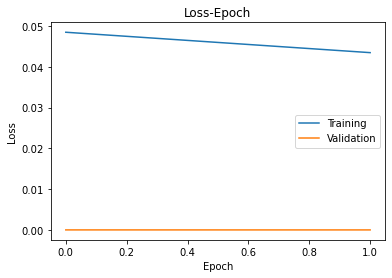

In [34]:
plt.plot(loss_tr, label = "Training")
plt.plot(dev_loss, label = "Validation")
plt.title("Loss-Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The model is about right. The loss of training decreased and the change of the loss of validation is small, also F1-Score can achieve 0.863 which means the model is about right. The figure looks like two staright line is because of there are only two epochs.

In [35]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['p'][-1]) 
            for x,y in zip(word2id_test, test_label)]

Y_te = (test_label-1).astype(int)

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8622222222222222
Precision: 0.8705325764583202
Recall: 0.8622222222222223
F1-Score: 0.8626363653938776


### Discuss how did you choose model hyperparameters ? 

**The results of model with differet number of hidden layers**

Different hidden dimensions were used in the model. The learning rate will keep the same with part 2.

From the table below, it is clear to find that the model with more hidden layer will have worse performance than only use one hidden layer. It might because the architecture is too deep that the model has lost some information during the training process. Also, the deeper model will have the bigger probability to overfit and gradient explosion.

When there does not have a hidden layer, the F1-Score is also worse than only use 1 hidden layer. We can conclude that a suitable number of the hidden layer is very important.

| Example | Hidden_dim  | lr | F1-Score  |
|:-:|:-:|:-:|:-:|
| Example1  | [] | 0.01 | 0.878|
| Example1  | [300] | 0.01 | 0.895|
| Example2  | [300, 400]  |  0.01 | 0.863|
| Example3  | [300, 400, 600] |  0.01 | 0.167|
| Example4  | [300, 400, 600, 700] |  0.01 | 0.167|

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.854  | 0.852  | 0.852  | 0.852  |
| Average Embedding (Pre-trained)  | 0.889  | 0.89  | 0.889  | 0.89  |
| Average Embedding (Pre-trained) + 2 hidden layers    |  0.870 | 0.863  | 0.863  | 0.862  |


Please discuss why your best performing model is better than the rest.

The table above showed that the best performing model is the Average Embedding(Pre-trained) which can achieve F1-Score with 0.890. There might have the reasons below:

1) The model used a pre-trained embedding layer which can represent features very well and the model do not need to update the embedding layer. It can avoid the model wrongly trained some features and update the embedding layer with the wrong elements.

2) The model only has one hidden layer which means it will not loss too much information during the training progress. Which also means the one hidden layer model will have a lower probability to overfit or gradient explosion.